In [1]:
# import all functions
from functions import *

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# function for doing classifying and such
def bond_lengths_WCUCMC(dic):

    data = dic["data"]

    n_frames = len(data)

    new_array_WC = []
    new_array_UC = []
    new_array_multi = []

    for frame_data in data:
        # cutoff_distance is the Pt-C cutoff and neighbor is the Pt-Pt cutoff, min_neighboors is the min number of neighbors for WC classification
        results = classify_and_find_distances_array(frame_data, cutoff_distance=3.0, neighbor_cutoff=3.5, min_neighbors=8)

        wc_co = results[np.where(results[:, 1] == "WC")[0]]
        uc_co = results[np.where(results[:, 1] == "UC")[0]]
        multi_co = results[np.where(results[:, 1] == "MC")[0]]


        if len(wc_co)>0:
            n_WC = wc_co.shape[0]
            mean_WC = np.mean(wc_co[:,2])
            std_WC = np.std(wc_co[:,2])
            new_array_WC.append([n_WC, mean_WC, std_WC])
        else:
            new_array_WC.append([0, 0, 0])
        


        if len(uc_co)>0:
            n_UC = uc_co.shape[0]
            mean_UC = np.mean(uc_co[:,2])
            std_UC = np.std(uc_co[:,2])

            new_array_UC.append([n_UC, mean_UC, std_UC])
        else:
            new_array_UC.append([0, 0, 0])

        if len(multi_co)>0:
            n_multi = len(multi_co)
            mean_multi = np.mean(multi_co[:,2])
            std_multi = np.std(multi_co[:,2])

            new_array_multi.append([n_multi, mean_multi, std_multi])
        else:
            new_array_multi.append([0, 0, 0])

    new_array_WC = np.array(new_array_WC)
    new_array_UC = np.array(new_array_UC)
    new_array_multi = np.array(new_array_multi)

    n_WC = np.mean(new_array_WC[:,0])
    n_UC = np.mean(new_array_UC[:,0])
    n_multi = np.mean(new_array_multi[:,0])

    r_WC = np.mean(new_array_WC[:,1][new_array_WC[:,1]>1])
    r_UC = np.mean(new_array_UC[:,1][new_array_UC[:,1]>1])
    r_multi = np.mean(new_array_multi[:,1][new_array_multi[:,1]>1])

    return n_WC, n_UC, n_multi, r_WC, r_UC, r_multi

In [6]:
# create the data dictionary
# edit paths

cluster_dict_147 = {}
#for i in ["148", "298", "398", "498", "623"]:
for i in ["148K_3","173K_6", "198K_6", "223K_6", "273K_6", "298K_6", "398K_6", "498K_6", "623K_6"]:

    ###########################################

    traj_dir = '/mnt/a/MD_Trajectories/PtCO/NPs/continued/cubo_147/'
    traj_name = f"Pt147_cuboct_{i}.all.bin"

    #p_name = "Pt309_cuboct_498K"
    #input_dir = "/mnt/a/MD_Trajectories/PtCO/NPs/Inputs/"
    #input_dir = "/mnt/sdcc/sdcc+u/nmarcella/MD_EXAFS_inputs/231228/"

    #pipeline.source.num_frames
    ###########################################
    
    traj_path = traj_dir + traj_name

    pipeline = import_file(traj_path)

    test_pl = MD_EXAFS_Analysis_Pipeline_PtCO(pipeline, file_params={"framerange": range(0,pipeline.source.num_frames,100),"atoms":{"Pt":1, "C":2, "O":3}, "cutoff":3}, custom_analysis_func=find_adsorbed_CO)
    #test_pl = MD_EXAFS_Binary_Pipeline_General(pipeline, file_params={"framerange": range(15999,16000),"atoms":{"Pt":1}, "cutoff":3})
    test_pl.run()

    data = test_pl.data
    n_atoms = test_pl.n_atoms_list

    n_atoms = np.array(n_atoms)
    n_co = np.mean(n_atoms[:,1])

    cluster_dict_147[i] = {"CO" :n_atoms[:,1], "data":data}

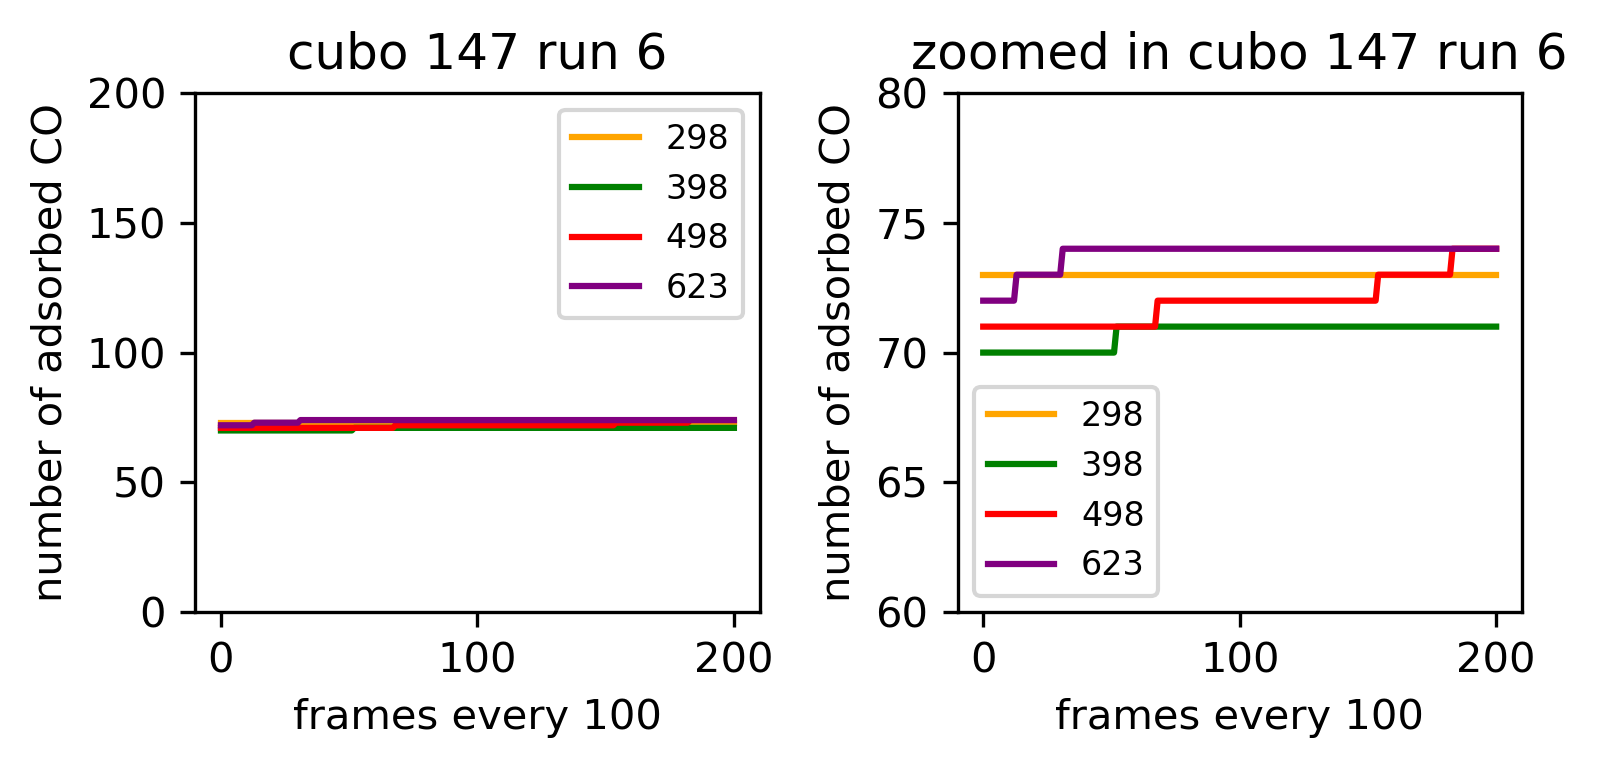

In [4]:
# plot coverage

size = 147
run = 6 

fig, ax = plt.subplots(1,2,figsize=(2*2.66,2.66), dpi=300)

colors = {"148":"blue", "298":"orange","398":"green", "498":"red", "623":"purple"}
#for i in ["148", "298", "398", "498", "623"]:
for i in ["298", "398", "498", "623"]:
    ax[0].plot(cluster_dict_147[i]["CO"], label=i, color=colors[i])
ax[0].set_title(f"cubo {size} run {run}")
ax[0].set_ylabel("number of adsorbed CO")
ax[0].set_xlabel("frames every 100")
ax[0].set_ylim(0,200)
ax[0].legend(fontsize=8)

for i in ["298", "398", "498", "623"]:
    ax[1].plot(cluster_dict_147[i]["CO"], label=i, color=colors[i])
ax[1].set_title(f"zoomed in cubo {size} run {run}")
ax[1].set_ylabel("number of adsorbed CO")
ax[1].set_xlabel("frames every 100")
ax[1].set_ylim(60,80)
ax[1].legend(fontsize=8)

fig.tight_layout()

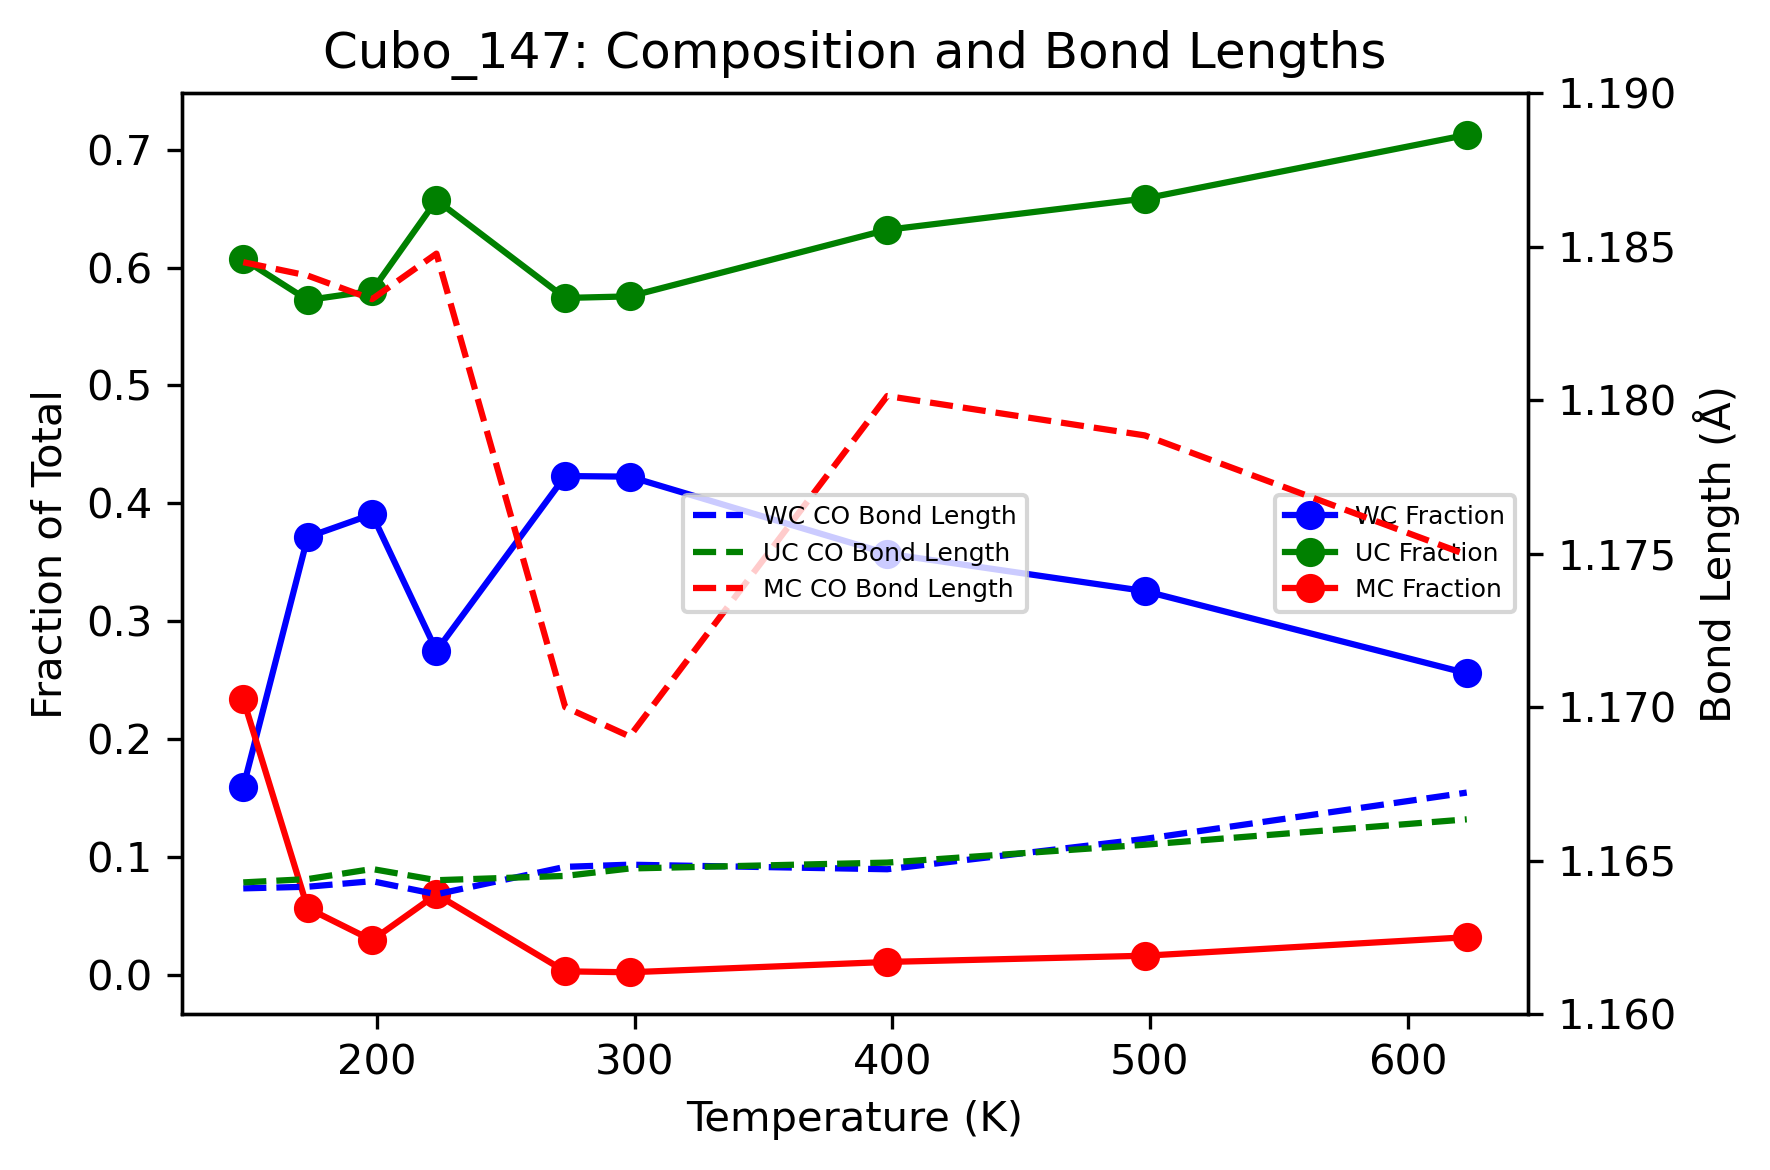

In [8]:
data_names = ["148K_3","173K_6", "198K_6", "223K_6", "273K_6", "298K_6", "398K_6", "498K_6", "623K_6"]
bond_lengths_147 = {}
for i in data_names:
    n_WC, n_UC, n_multi, r_WC, r_UC, r_multi = bond_lengths_WCUCMC(cluster_dict_147[i])
    bond_lengths_147[i] = {"n_WC": n_WC, "n_UC": n_UC, "n_multi": n_multi, "r_WC": r_WC, "r_UC": r_UC, "r_multi": r_multi}

fig, ax1 = plt.subplots(figsize=(6, 4), dpi=300)

# Aggregate data for plotting
temperatures = np.array([int(i.split("K")[0]) for i in data_names])
totals = np.array([bond_lengths_147[i]["n_WC"] + bond_lengths_147[i]["n_UC"] + bond_lengths_147[i]["n_multi"] for i in data_names])
n_WC = np.array([bond_lengths_147[i]["n_WC"] / total for i, total in zip(data_names, totals)])
n_UC = np.array([bond_lengths_147[i]["n_UC"] / total for i, total in zip(data_names, totals)])
n_multi = np.array([bond_lengths_147[i]["n_multi"] / total for i, total in zip(data_names, totals)])

# Plotting fractions on primary y-axis
ax1.plot(temperatures, n_WC, label="WC Fraction", marker='o', color='b')
ax1.plot(temperatures, n_UC, label="UC Fraction", marker='o', color='g')
ax1.plot(temperatures, n_multi, label="MC Fraction", marker='o', color='r')
ax1.set_xlabel("Temperature (K)")
ax1.set_ylabel("Fraction of Total")
ax1.legend(loc="center right", fontsize=6)

# Secondary axis for bond lengths
ax2 = ax1.twinx()
r_WC = np.array([bond_lengths_147[i]["r_WC"] for i in data_names])
r_UC = np.array([bond_lengths_147[i]["r_UC"] for i in data_names])
r_multi = np.array([bond_lengths_147[i]["r_multi"] for i in data_names])
ax2.plot(temperatures, r_WC, label="WC CO Bond Length", linestyle='--', color='b')
ax2.plot(temperatures, r_UC, label="UC CO Bond Length", linestyle='--', color='g')
ax2.plot(temperatures, r_multi, label="MC CO Bond Length", linestyle='--', color='r')
ax2.set_ylabel("Bond Length (Å)")
ax2.set_ylim(1.16, 1.19)
ax2.legend(loc="center", fontsize=6)

plt.title("Cubo_147: Composition and Bond Lengths")
plt.tight_layout()
plt.show()